In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import pandas as pd
import os
import shutil
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from __future__ import print_function, division
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models, datasets
import warnings
warnings.filterwarnings("ignore")
plt.ion()

In [3]:
BASE_DIR = os.path.normpath("/content/gdrive/My Drive/DG/")
os.listdir(BASE_DIR)

['train.csv',
 'test.csv',
 'LICENSE.txt',
 'CC-BY-4.0.txt',
 'Images',
 '.ipynb_checkpoints',
 'Retinopathy.ipynb',
 'dataset']

In [0]:
train_data = pd.read_csv(os.path.join(BASE_DIR, 'train.csv'))[['Image name', 'Retinopathy grade']]
test_data = pd.read_csv(os.path.join(BASE_DIR, 'test.csv'))

if os.path.exists(os.path.join(BASE_DIR, 'dataset')):
  shutil.rmtree(os.path.join(BASE_DIR, 'dataset'))
else:
  os.mkdir(os.path.join(BASE_DIR, 'dataset'))
  os.mkdir(os.path.join(BASE_DIR, 'dataset', 'train'))
  os.mkdir(os.path.join(BASE_DIR, 'dataset', 'test'))

  for i in range(5):
    os.mkdir(os.path.join(BASE_DIR, 'dataset', 'train', str(i)))
    os.mkdir(os.path.join(BASE_DIR, 'dataset', 'test', str(i)))

for idx, row in train_data.iterrows():
  shutil.copy(os.path.join(BASE_DIR, 'Images', 'train', row['Image name'] + '.jpg'), os.path.join(BASE_DIR, 'dataset', 'train', str(row['Retinopathy grade'])))
  # print(row['Image name'], row['Retinopathy grade'], end="\n----------\n")
for idx, row in test_data.iterrows():
  shutil.copy(os.path.join(BASE_DIR, 'Images', 'test', row['Image name'] + '.jpg'), os.path.join(BASE_DIR, 'dataset', 'test', str(row['Retinopathy grade'])))
 

In [0]:
#Prepare datatransforms
data_transforms = {
    'train': transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(), 
    transforms.ToTensor()
    ]),
    'test': transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
    ])
}

In [0]:
data_dir = os.path.join(BASE_DIR, 'dataset')

In [6]:
#load image_folders into dataset 
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}

#create dataloader for batched input to Neural Network
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}

#Get dataset sizes and class names
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

#Check if GPU availabale for compute
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(dataset_sizes, class_names, device, sep="\n")

{'train': 413, 'test': 103}
['0', '1', '2', '3', '4']
cuda:0


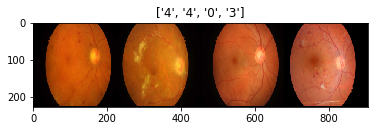

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [0]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 5.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 5)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [20]:
import time, copy
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------
train Loss: 1.1139 Acc: 0.5884
test Loss: 2.2500 Acc: 0.4854

Epoch 1/19
----------
train Loss: 1.0343 Acc: 0.6029
test Loss: 1.4629 Acc: 0.5146

Epoch 2/19
----------
train Loss: 0.8960 Acc: 0.6586
test Loss: 1.0842 Acc: 0.6117

Epoch 3/19
----------
train Loss: 0.7129 Acc: 0.7215
test Loss: 1.1574 Acc: 0.5922

Epoch 4/19
----------
train Loss: 0.7659 Acc: 0.7143
test Loss: 1.1546 Acc: 0.5825

Epoch 5/19
----------
train Loss: 0.7532 Acc: 0.6780
test Loss: 1.0400 Acc: 0.5631

Epoch 6/19
----------
train Loss: 0.6529 Acc: 0.7433
test Loss: 1.0391 Acc: 0.6214

Epoch 7/19
----------
train Loss: 0.6485 Acc: 0.7409
test Loss: 1.1230 Acc: 0.5631

Epoch 8/19
----------
train Loss: 0.6027 Acc: 0.7724
test Loss: 1.2076 Acc: 0.5437

Epoch 9/19
----------
train Loss: 0.6196 Acc: 0.7651
test Loss: 1.1456 Acc: 0.6019

Epoch 10/19
----------
train Loss: 0.6337 Acc: 0.7772
test Loss: 1.1983 Acc: 0.5631

Epoch 11/19
----------
train Loss: 0.6287 Acc: 0.7603
test Loss: 1.1100 Acc

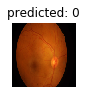

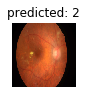

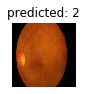

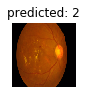

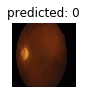

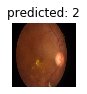

In [21]:
visualize_model(model_ft)


In [0]:
PATH = BASE_DIR + '/model20.pt'
torch.save(model_ft.state_dict(), PATH)